In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 16
def set_figsize(width, height):
    pylab.rcParams['figure.figsize'] = width, height
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import ta
from datetime import datetime
import config
import MetaTrader5 as mt5
from tqdm import tqdm
from pandas.plotting import scatter_matrix
import backtrader as bt
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo

Loading BokehJS ...

# Initialize MT5

In [2]:
if not mt5.initialize(config.PATH,
                      login=config.USERNAME,
                      password=config.PASSWORD,
                      server=config.SERVER
                      ):
    print("initialize() failed")
    mt5.shutdown()
# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=2715, maxbars=100000, codepage=0, ping_last=215846, community_balance=0.0, retransmission=0.0, company='MetaQuotes Software Corp.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\ChiChaChai\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\ChiChaChai\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 2715, '26 Nov 2020')


# Import data

In [3]:

symbol = 'AUDUSDm'

start_date =  datetime(2020, 1, 1)
timeframe = mt5.TIMEFRAME_D1
df = pd.DataFrame(mt5.copy_rates_range(symbol, timeframe, start_date, datetime.now()))
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.drop(columns=['spread', 'real_volume'], inplace=True)

In [4]:
df.head()

,open,high,low,close,volume
time,,,,,
2020-01-02,0.70135,0.70188,0.69779,0.69825,14553
2020-01-03,0.69825,0.69856,0.69296,0.69528,16879
2020-01-05,0.69403,0.69429,0.69322,0.69425,1025
2020-01-06,0.69424,0.69569,0.69247,0.69360,15680
2020-01-07,0.69360,0.69383,0.68495,0.68579,17798


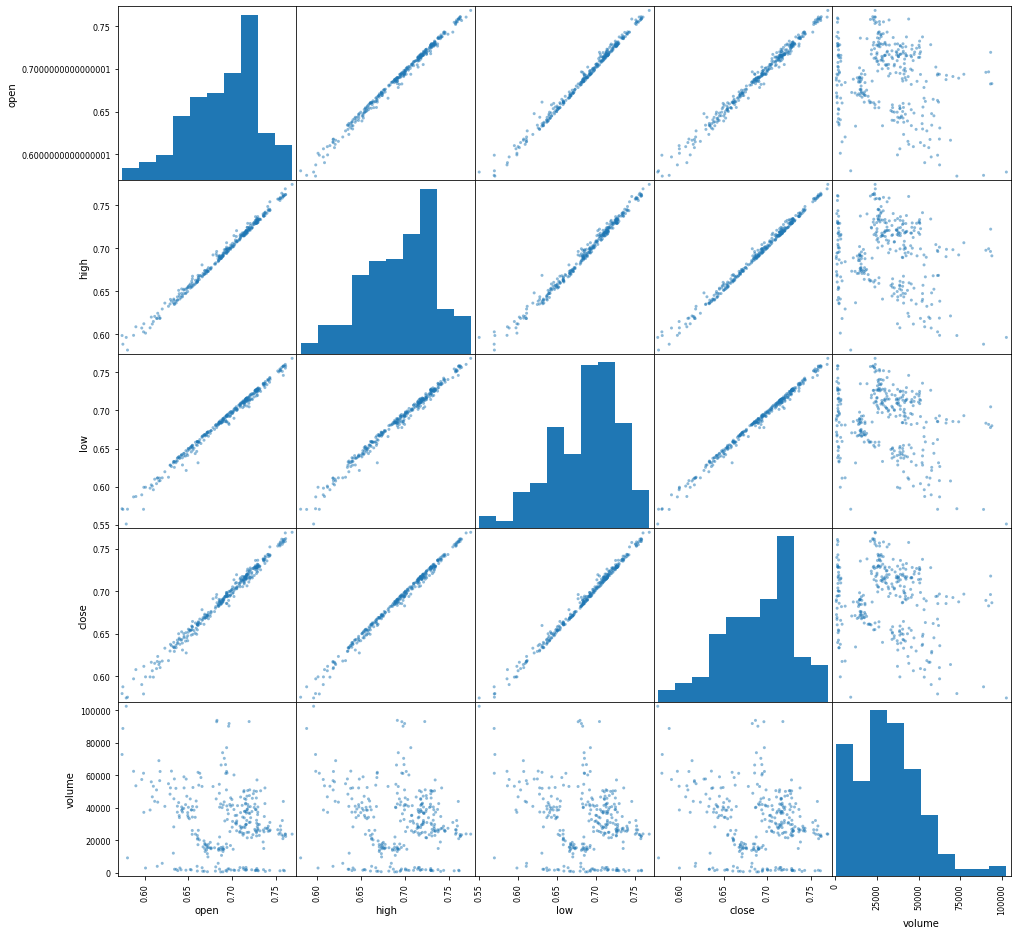

In [5]:
scatter_matrix(df, figsize=(16, 16))
plt.show()

Order(action='SELL', size=1000, price=0.69425)
Order(action='SELL', size=1000, price=0.68406)
Order(action='SELL', size=1000, price=0.67044)
clear order [Order(action='SELL', size=1000, price=0.69425), Order(action='SELL', size=1000, price=0.68406)] buy 2000 at 0.67507
remaining debt port 670.44
Order(action='SELL', size=1000, price=0.67307)
Order(action='SELL', size=1000, price=0.66111)
Order(action='SELL', size=1000, price=0.65063)
clear order [Order(action='SELL', size=1000, price=0.67044), Order(action='SELL', size=1000, price=0.67307), Order(action='SELL', size=1000, price=0.66111)] buy 3000 at 0.65458
remaining debt port 650.63
Order(action='SELL', size=1000, price=0.64937)
Order(action='SELL', size=1000, price=0.62739)
Order(action='SELL', size=1000, price=0.61834)
Order(action='SELL', size=1000, price=0.61013)
Order(action='SELL', size=1000, price=0.5989)
Order(action='SELL', size=1000, price=0.5791)
clear order [Order(action='SELL', size=1000, price=0.65063), Order(action='SEL

<IPython.core.display.Javascript object>


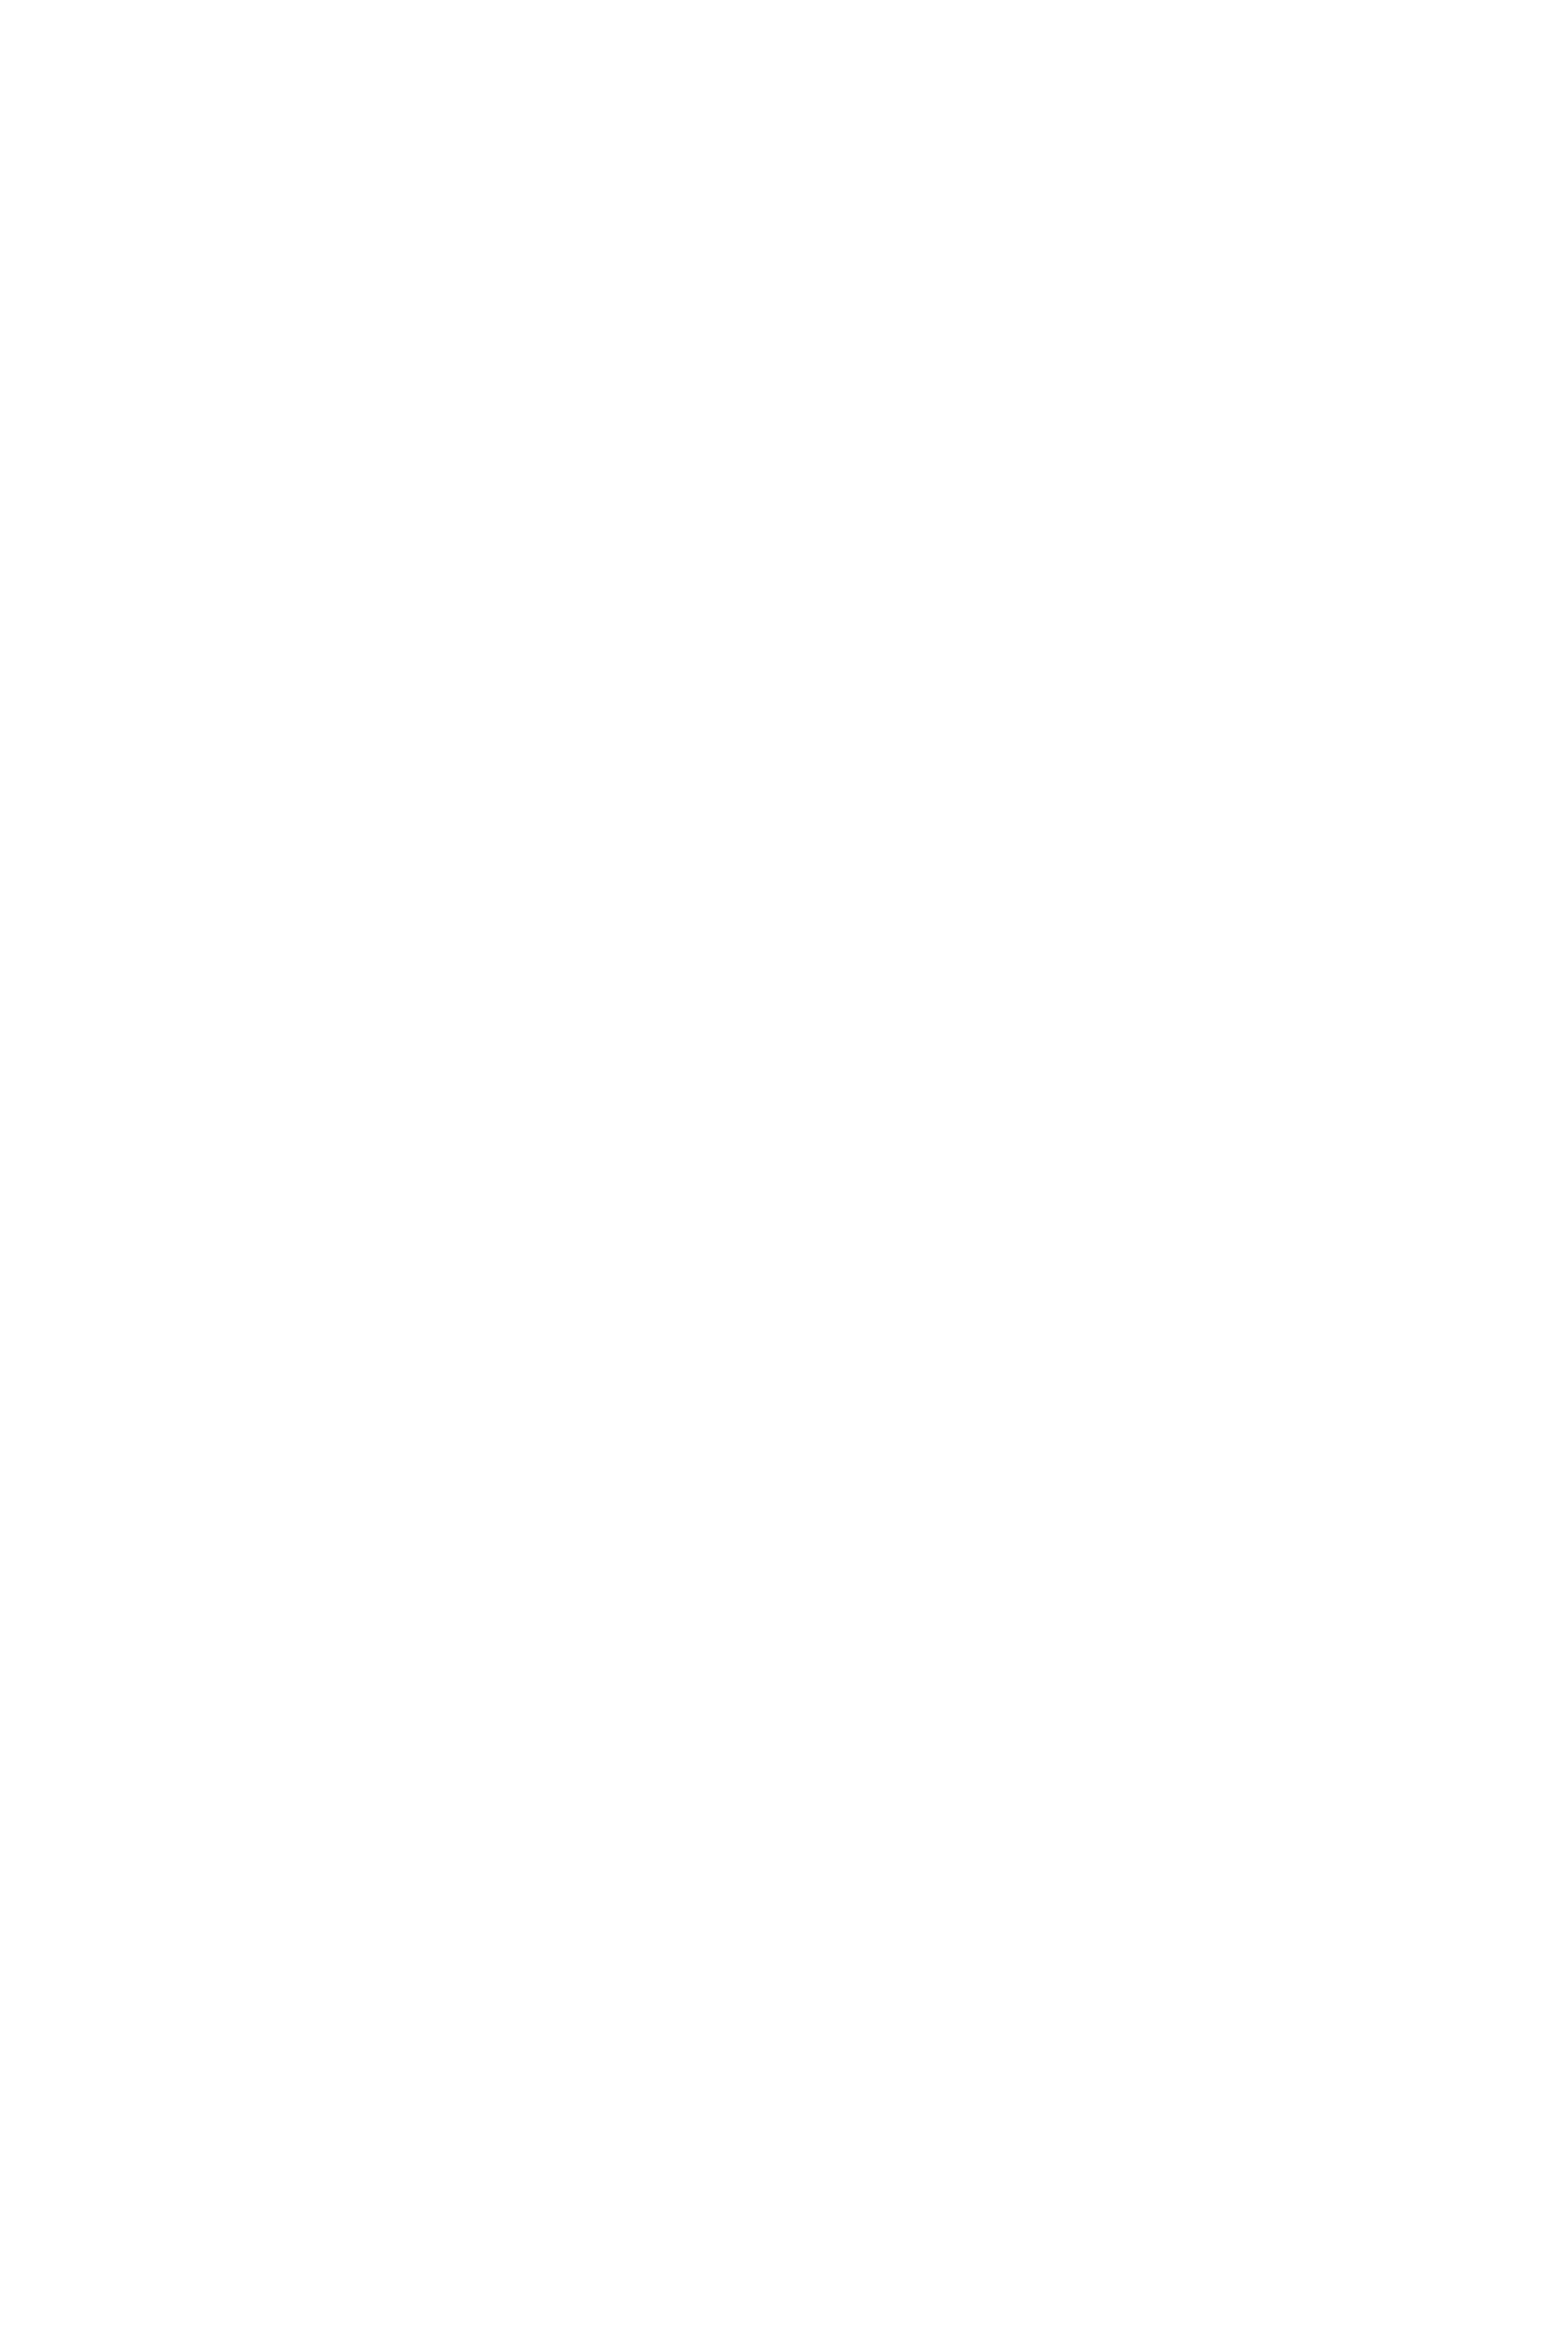

[[<Figure size 1152x1728 with 4 Axes>]]

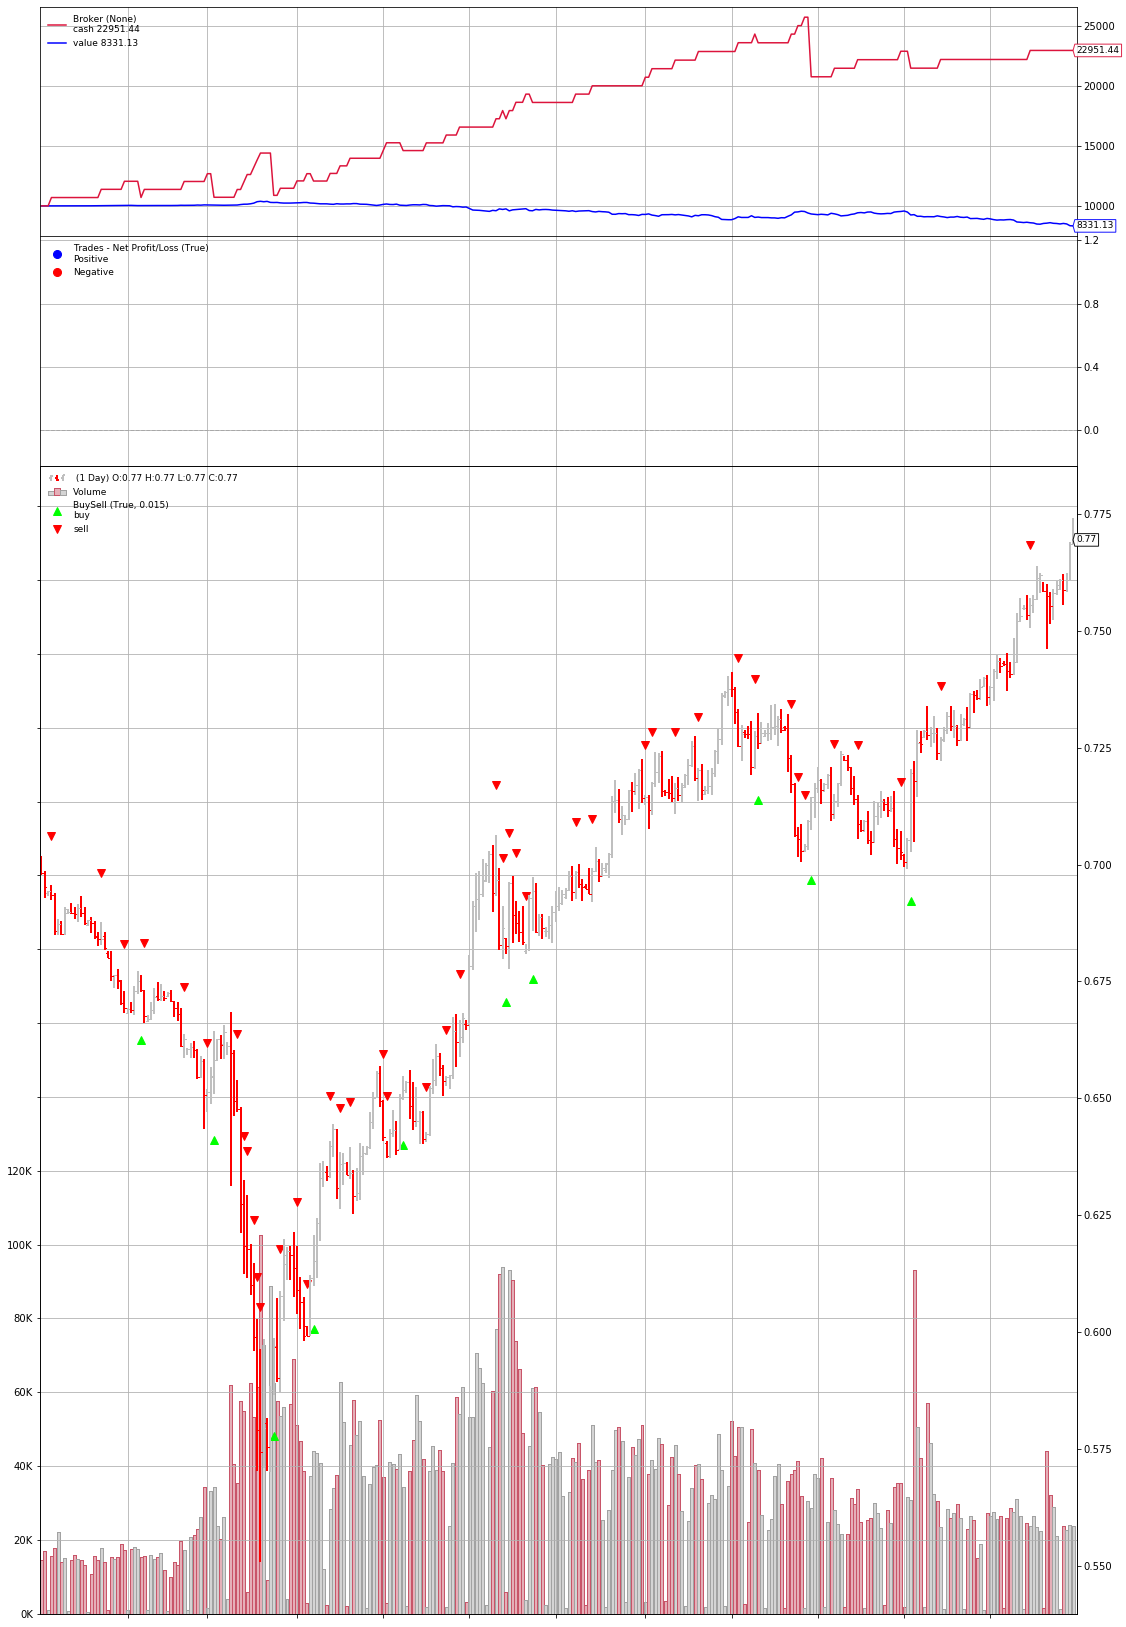

In [7]:
set_figsize(16, 24)
Order = namedtuple('Order', ['action', 'size', 'price'])
SELL = 'SELL'
BUY = 'BUY'

class GridTradingStrategy(bt.Strategy):
    

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self, grid_size, df, grid_value):
        self.grid_size = grid_size
        self.df = df
        self.grid_value = grid_value
        self.__define_grid()
        
        self.crossovers = [bt.ind.CrossOver(self.datas[0].close, grid, plot=False) for grid in self.grids]
        self.portfolio = []
        
    
    def __define_grid(self):
        self.grids = np.arange(self.df['close'].min(), self.df['close'].max(), self.grid_size)
        self.grids = [bt.Max(-np.inf, grid) for grid in self.grids]

    def next(self):
        crossups = [crossover > 0 for crossover in self.crossovers]
        crossdowns = [crossover < 0 for crossover in self.crossovers]
        
        # buy
        if any(crossdowns):
            self.buy(size=self.grid_value)
            order = Order(action=BUY, size=self.grid_value, price=self.data.close.get()[0])
            self.portfolio.append(order)
            print(order)
        # sell all below
        elif any(crossups):
            sell_grid = self.grids[np.argwhere(crossups)[0, 0]]
            bought_orders = list(filter(lambda order: order.action == BUY and order.price < sell_grid, self.portfolio))
            # clear order
            for order in bought_orders:
                self.portfolio.remove(order)
            if len(bought_orders) > 0:
                sell_size = self.grid_value * len(bought_orders)
                self.sell(size=sell_size)
                print('clear order', bought_orders, 'sell', sell_size)
class GridTradingShortStrategy(bt.Strategy):
    def __init__(self, grid_size, df, grid_value):
        self.grid_size = grid_size
        self.df = df
        self.grid_value = grid_value
        self.__define_grid()
        
        self.crossovers = [bt.ind.CrossOver(self.datas[0].close, grid, plot=False) for grid in self.grids]
        self.portfolio = []
        
    
    def __define_grid(self):
        self.grids = np.arange(self.df['close'].min(), self.df['close'].max(), self.grid_size)
        self.grids = [bt.Max(-np.inf, grid) for grid in self.grids]

    def next(self):
        crossups = [crossover > 0 for crossover in self.crossovers]
        crossdowns = [crossover < 0 for crossover in self.crossovers]
        
        # sell
        if any(crossdowns):
            self.sell(size=self.grid_value)
            order = Order(action=SELL, size=self.grid_value, price=self.data.close.get()[0])
            self.portfolio.append(order)
            print(order)
        # buy to fill up
        elif any(crossups):
            buy_grid = self.grids[np.argwhere(crossups)[0, 0]]
            sold_orders = list(filter(lambda order: order.action == SELL and order.price > buy_grid, self.portfolio))
            # clear order
            for order in sold_orders:
                self.portfolio.remove(order)
            if len(sold_orders) > 0:
                buy_size = self.grid_value * len(sold_orders)
                self.buy(size=buy_size)
                print('clear order', sold_orders, 'buy', buy_size, 'at', self.data.close.get()[0])
                print('remaining debt port', sum(order.price * order.size for order in self.portfolio))
                
class TestStrategy(bt.Strategy):
    def next(self):
        self.buy(size=100)

data_feed = bt.feeds.PandasData(dataname=df)
cerebro = bt.Cerebro()
cerebro.broker.set_cash(10000.0)

cerebro.adddata(data_feed)
# cerebro.addstrategy(GridTradingStrategy, grid_size=0.01, df=df, grid_value=1000)
cerebro.addstrategy(GridTradingShortStrategy, grid_size=0.01, df=df, grid_value=1000)
# cerebro.addstrategy(TestStrategy)

cerebro.run()
cerebro.plot(iplot=True, style='bar')

# b = Bokeh(style='bar', plot_mode='single', scheme=Tradimo())
# cerebro.plot(b)

In [99]:

Order

__main__.Order

In [38]:
df['close'].max()

0.76949